In [1]:
# ARTS needs spectroscopy catalogue
import os
os.environ['ARTS_DATA_PATH']= '/home/pc2943/arts-cat-data/'

# helper function for using ARTS
import sys
sys.path.append('/home/pc2943/thingases23')
import absorption_funcs as ab


import numpy as np
import pyarts

import matplotlib.pyplot as plt
import seaborn as sns

import konrad
from konrad.utils import get_quadratic_pgrid
from konrad.atmosphere import Atmosphere
import scipy

import schwarzschild_solver as s

/home/pc2943/.local/lib/python3.9/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


Use the RTE-RRTMG solver (https://github.com/earth-system-radiation/rte-rrtmgp/blob/main/rte-kernels/mo_rte_solver_kernels.F90) to solve the flux up and down at the methane band center.

In [2]:
### set up atmosphere using konrad
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)


In [4]:
# use ARTS for line-by-line reference
arts_atmosphere = atmosphere.to_atm_fields_compact()

# return monochromatic flux up, flux down, and layer optical depth
flux_up_ch4, flux_down_ch4, _, _, tau_ch4, _ = ab.calc_lbl_rt(arts_atmosphere, species = ["CH4"], w_grid = np.array([1306]))
tau = np.cumsum(tau_ch4[0][::-1])[::-1] # cumulative optical depth

In [5]:
D = 2 # two-stream coefficient that matches with ARTS
# use the RTE solver
# only use for one wavenumber at a time, loop for spectrum
# input LAYER optical depth
rte_up, rte_down = s.lw_solver_noscat_oneangle(D*tau_ch4[0], atmosphere.data_vars["T"][1][0], np.array([1306]), 1)

In [6]:
# another implementation
# can use for wavenumber array, with CUMULATIVE optical depth
# assumes unit surface emissivity
alt_down = s.flux_down_profile(atmosphere.data_vars["T"][1][0], plev, D*tau.T, np.array([1306]))
alt_up = s.flux_up_profile(atmosphere.data_vars["T"][1][0], plev, D*tau.T, np.array([1306]))

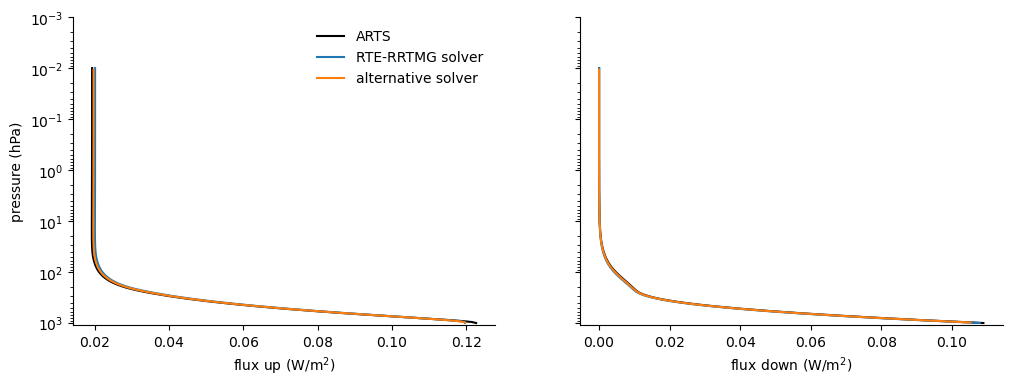

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4), sharey = True)
ax1.semilogy(flux_up_ch4[0, :], phlev/100, color = 'black')
ax1.semilogy(rte_up, phlev/100)
ax1.semilogy(alt_up, plev/100)


ax1.set_ylim([1100, 0.001])
ax1.legend(["ARTS", "RTE-RRTMG solver", "alternative solver"], frameon = False)
ax1.set_xlabel("flux up (W/m$^2$)")
ax1.set_ylabel("pressure (hPa)")

ax2.semilogy(flux_down_ch4[0, :], phlev/100, color = 'black')
ax2.semilogy(rte_down, phlev/100)
ax2.semilogy(alt_down, plev/100)
ax2.set_xlabel("flux down (W/m$^2$)")

sns.despine()
plt.show()


$\to$ small discrepancies between ARTS, the RTE-RRTMG and the alternative implementation arise from differences in the treatment of surface emission as well as different treatment of layers (calculating the source as a layer average vs. calculating radiative transfer at the interfaces.)